# MNIST MLP Classification Project

This notebook demonstrates a complete machine learning pipeline for MNIST digit classification using PyTorch:

1. **Data Loading & EDA**: Load MNIST dataset and explore the data
2. **Model Definition**: Multi-Layer Perceptron with configurable hidden layers
3. **Hyperparameter Tuning**: Use RandomizedSearchCV with Stratified K-Fold
4. **Training & Monitoring**: Train with best params, monitor loss/accuracy curves
5. **Evaluation**: Comprehensive testing with metrics and visualizations

**Key Features:**
- Hyperparameter tuning for architecture, learning rate, batch size, optimizer
- Training monitoring with validation curves
- Detailed evaluation metrics (accuracy, precision, recall, confusion matrix)
- Sample predictions visualization

In [9]:
# Import pytorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Import data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import scikit-learn libraries
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix

In [10]:
# Load MNIST dataset

# Define transformations for the dataset
transform = transforms.Compose([
    transforms.ToTensor(), # transform images to tensor
    transforms.Normalize((0.5,), (0.5,)) # normalize the images 0.5 mean and 0.5 std
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders which will help in batching the data for testing
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Dataset Overview:
Training samples: 60000
Test samples: 10000
Image shape: torch.Size([1, 28, 28])
Classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


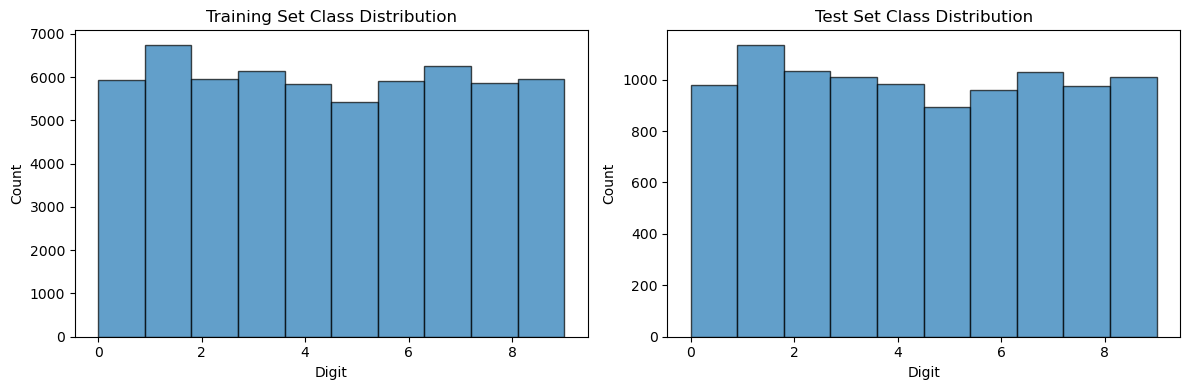

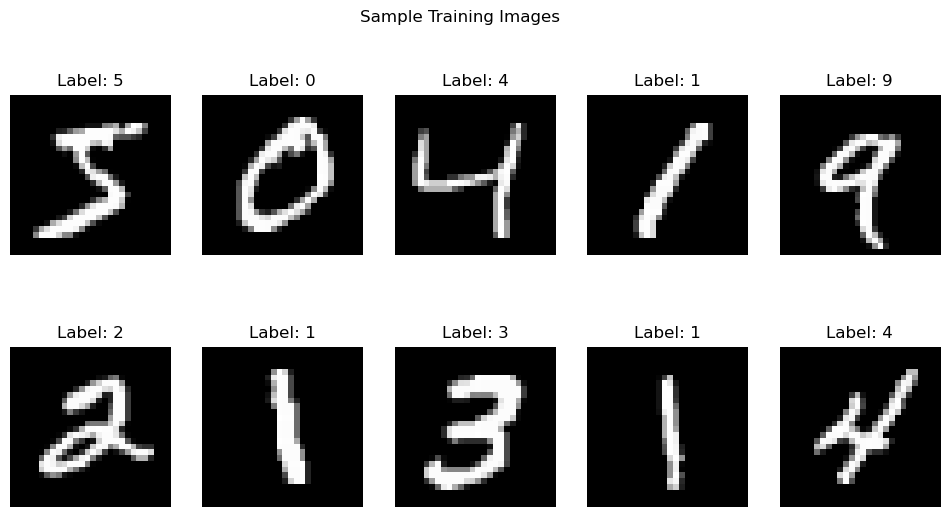

In [11]:
# Exploratory Data Analysis (EDA)
print("Dataset Overview:")
print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Image shape: {train_dataset[0][0].shape}")
print(f"Classes: {list(range(10))}")

# Class distribution
train_labels = [label for _, label in train_dataset]
test_labels = [label for _, label in test_dataset]

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(train_labels, bins=10, alpha=0.7, edgecolor='black')
plt.title('Training Set Class Distribution')
plt.xlabel('Digit')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(test_labels, bins=10, alpha=0.7, edgecolor='black')
plt.title('Test Set Class Distribution')
plt.xlabel('Digit')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Sample images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i in range(10):
    img, label = train_dataset[i]
    ax = axes[i//5, i%5]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')
plt.suptitle('Sample Training Images')
plt.show()

In [12]:
# Define MLP model
# Architecture: Input (784) -> Hidden layers (128, 64) -> Output (10 classes with softmax)
class MLP(nn.Module):
    def __init__(self, input_size=784, hidden_sizes=[128, 64], num_classes=10):
        super(MLP, self).__init__() # Initialize the nn.Module
        layers = []
        in_size = input_size # Input layer size
        for h_size in hidden_sizes:
            layers.append(nn.Linear(in_size, h_size))  # Fully connected layer
            layers.append(nn.ReLU())  # Activation function
            in_size = h_size # Update input size for next layer
        layers.append(nn.Linear(in_size, num_classes))  # Output layer
        self.layers = nn.Sequential(*layers)  # Stack all layers
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten 28x28 images to 784 vector
        return self.layers(x)  # Forward pass through all layers

In [13]:
# Sklearn wrapper Allows PyTorch model to work with sklearn's hyperparameter tuning tools
class TorchMLPClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, hidden_sizes=[128, 64], learning_rate=0.01, epochs=10, batch_size=64, optimizer='adam'):
        self.hidden_sizes = hidden_sizes 
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.optimizer = optimizer
        self.model = None 
        self.criterion = nn.CrossEntropyLoss()  # Loss function for multi-class classification
    
    def fit(self, X, y):
        # Initialize model with current hyperparameters
        self.model = MLP(hidden_sizes=self.hidden_sizes)
        
        # Select optimizer
        if self.optimizer == 'adam':
            optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        elif self.optimizer == 'sgd':
            optimizer = optim.SGD(self.model.parameters(), lr=self.learning_rate)
        else:
            optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        
        # Convert to PyTorch tensors and create DataLoader
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.long)
        dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor) 
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        
        # Training loop
        for epoch in range(self.epochs):
            for inputs, labels in dataloader:
                optimizer.zero_grad()  # Clear gradients
                outputs = self.model(inputs)  # Forward pass
                loss = self.criterion(outputs, labels)  # Compute loss
                loss.backward()  # Backward pass
                optimizer.step()  # Update weights
        return self
    
    def predict(self, X):
        # Make predictions (no gradients needed)
        X_tensor = torch.tensor(X, dtype=torch.float32)
        with torch.no_grad():
            outputs = self.model(X_tensor) # Forward pass
            _, predicted = torch.max(outputs, 1)  # Get class with highest probability
        return predicted.numpy()
    
    def score(self, X, y):
        # Return accuracy for sklearn compatibility
        predictions = self.predict(X)
        return accuracy_score(y, predictions)

In [14]:
# Prepare data for hyperparameter tuning (use subset for speed)

train_subset = torch.utils.data.Subset(train_dataset, range(5000)) # Use 5k samples for tuning  
train_loader_subset = DataLoader(train_subset, batch_size=len(train_subset), shuffle=False) # Load all samples in one batch

X_train, y_train = next(iter(train_loader_subset)) # iterate once to get all data
X_train = X_train.numpy()
y_train = y_train.numpy()

# Flatten for MLP input (28x28 -> 784)
X_train = X_train.reshape(X_train.shape[0], -1)

In [15]:
# Hyperparameter tuning with RandomizedSearchCV using Stratified K-Fold
param_distributions = {
    'hidden_sizes': [[128], [128, 64]],  # Network architectures
    'learning_rate': [0.01, 0.1],  # Learning rates to try
    'epochs': [3, 5],  # Number of training epochs
    'batch_size': [64],  # Batch sizes for mini-batch training
    'optimizer': ['adam', 'sgd']  # Optimization algorithms
}

# No pipeline needed since data is pre-normalized
mlp = TorchMLPClassifier()
stratified_kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(
    mlp, 
    param_distributions, 
    n_iter=5,  # Try 5 random combinations
    cv=stratified_kfold, 
    scoring='accuracy', 
    verbose=1, 
    random_state=42
)
random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best cross-validation score:", random_search.best_score_)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
Best parameters: {'optimizer': 'adam', 'learning_rate': 0.01, 'hidden_sizes': [128], 'epochs': 3, 'batch_size': 64}
Best cross-validation score: 0.8362


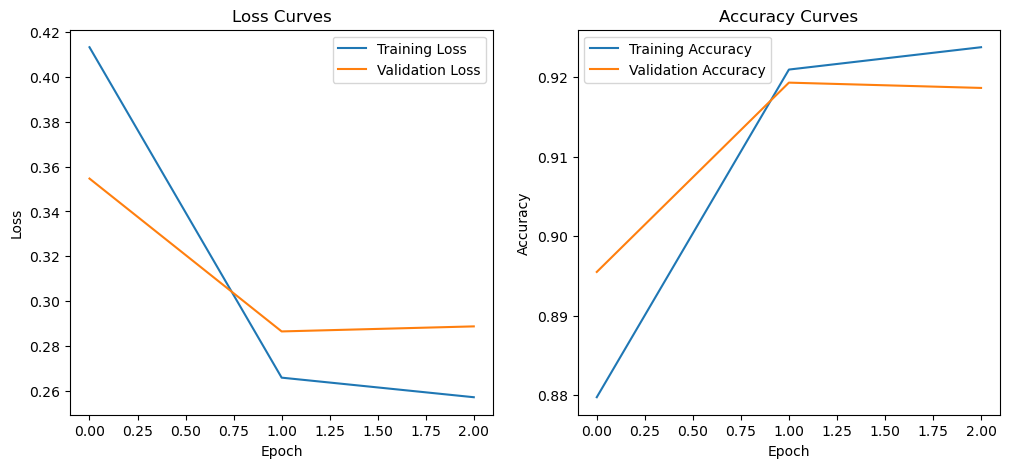

In [17]:
# Train full model with best parameters and plot loss/accuracy curves
best_params = random_search.best_params_
model = MLP(hidden_sizes=best_params['hidden_sizes'])

# Initialize optimizer with best parameters
if best_params['optimizer'] == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])
elif best_params['optimizer'] == 'sgd':
    optimizer = optim.SGD(model.parameters(), lr=best_params['learning_rate'])

criterion = nn.CrossEntropyLoss()

# Split full training data into train/validation for monitoring using random_split because we use pytorch dataset 
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size]) 
train_loader = DataLoader(train_subset, batch_size=best_params['batch_size'], shuffle=True)
val_loader = DataLoader(val_subset, batch_size=best_params['batch_size'], shuffle=False)

epochs = best_params['epochs']
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop with validation monitoring
for epoch in range(epochs):

    # Training phase
    model.train()
    epoch_train_loss = 0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    train_losses.append(epoch_train_loss / len(train_loader))
    train_accuracies.append(correct_train / total_train)
    
    # Validation phase
    model.eval()
    epoch_val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            epoch_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    val_losses.append(epoch_val_loss / len(val_loader))
    val_accuracies.append(correct_val / total_val)

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(train_losses, label='Training Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_title('Loss Curves')

ax2.plot(train_accuracies, label='Training Accuracy')
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.set_title('Accuracy Curves')

plt.show()

In [18]:
# Evaluate on test set (completely unseen data)
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.9177


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       980
           1       0.95      0.98      0.97      1135
           2       0.93      0.88      0.90      1032
           3       0.82      0.96      0.88      1010
           4       0.97      0.85      0.91       982
           5       0.97      0.88      0.92       892
           6       0.91      0.97      0.94       958
           7       0.89      0.92      0.90      1028
           8       0.93      0.87      0.90       974
           9       0.89      0.89      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



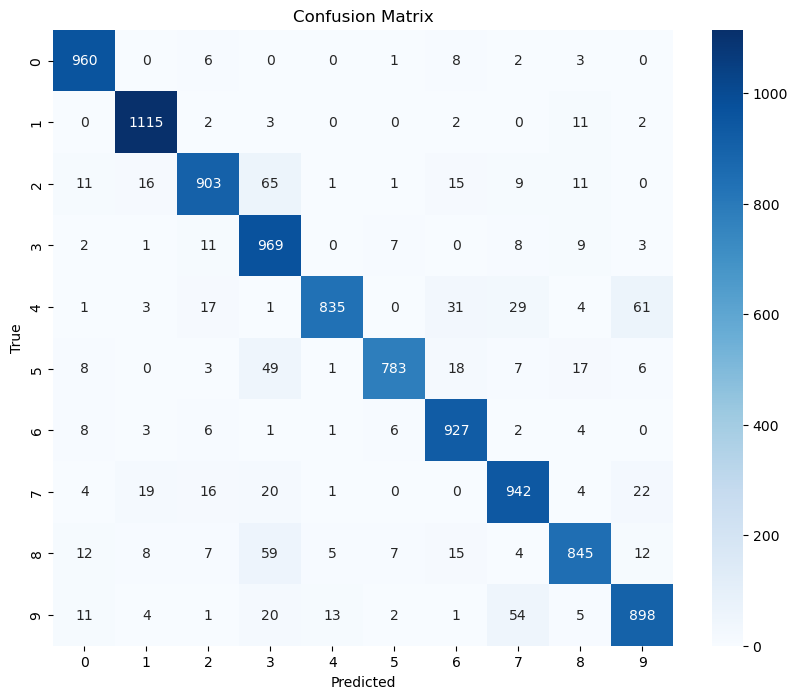

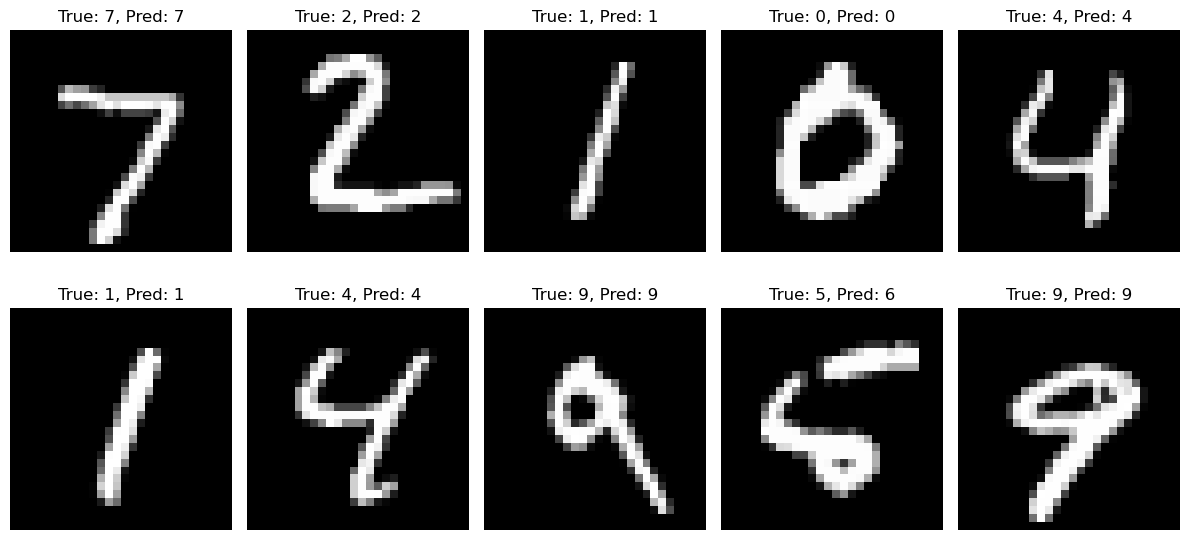

In [19]:
# Detailed evaluation metrics
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

# Classification report: precision, recall, f1-score per class
print("Classification Report:")
print(classification_report(all_labels, all_preds))

# Confusion matrix: shows prediction errors
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Sample predictions: visual check of model performance
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i in range(10):
    img, label = test_dataset[i]
    pred = model(img.unsqueeze(0)).argmax().item()
    ax = axes[i//5, i%5]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f'True: {label}, Pred: {pred}')
    ax.axis('off')
plt.tight_layout()
plt.show()